### 임포팅

In [4]:
import extcolors
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import random
from PIL import Image
import pandas as pd

from colorthief import ColorThief
import matplotlib.pyplot as plt
import colorsys

from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input
from tensorflow.keras.applications.vgg19 import VGG19
from tensorflow.keras.models import Model
from keras.layers import Dense, Dropout, Flatten
from tqdm import tqdm
from pathlib import Path

import os
import sys
import cv2
import io

from rembg.bg import remove

import nltk
from nltk import word_tokenize

import re


2023-02-22 09:00:13.379380: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


### 데이터셋 읽어오기

In [5]:
df = pd.read_csv("fashion_dataset.csv")
df = df[['PID', 'GENDER', 'TITLE', 'CATEGORY', 'season', 'NEW_TAG', 'rem_img', 'file_loc']]
df

,PID,GENDER,TITLE,CATEGORY,season,NEW_TAG,rem_img,file_loc
0,Men-ame001,Men,와이드한 매력,americancasual,봄,"['봄', '아메리칸', '캐주얼', '가든익스프레스', '갤럭시', '기타', '...",fashion_dataset_bgrem/americancasual/bgrem_ame...,fashion_dataset/americancasual/americancasual_...
1,Men-ame002,Men,시티보이 룩,americancasual,봄,"['봄', '아메리칸', '캐주얼', '갤럭시', '데님', '팬츠', '로맨틱크라...",fashion_dataset_bgrem/americancasual/bgrem_ame...,fashion_dataset/americancasual/americancasual_...
2,Men-ame003,Men,빈티지한 색감,americancasual,봄,"['봄', '아메리칸', '캐주얼', '논픽', '부츠', '블런드스톤', '블루멀...",fashion_dataset_bgrem/americancasual/bgrem_ame...,fashion_dataset/americancasual/americancasual_...
3,Men-ame004,Men,강렬한 색감,americancasual,겨울,"['겨울', '아메리칸', '캐주얼', '레더', '스웨이드', '컬러포인트', '...",fashion_dataset_bgrem/americancasual/bgrem_ame...,fashion_dataset/americancasual/americancasual_...
4,Men-ame005,Men,빈티지 무드,americancasual,봄,"['봄', '아메리칸', '캐주얼', '더블유엠씨', '디미토', '디미트리블랙',...",fashion_dataset_bgrem/americancasual/bgrem_ame...,fashion_dataset/americancasual/americancasual_...
...,...,...,...,...,...,...,...,...
2873,Women-str296,Women,트렌디한 셋업,street,겨울,"['셋업코디', '트위드', '오버핏', '레이어드룩', '모노톤', '럭셔리', ...",fashion_dataset_bgrem/street/bgrem_street_Wome...,fashion_dataset/street/street_Women_296.jpg
2874,Women-str297,Women,패셔니스타,street,가을,"['한파', '플리스', '그래픽', '부츠컷', '유니크', '스트링', '가을'...",fashion_dataset_bgrem/street/bgrem_street_Wome...,fashion_dataset/street/street_Women_297.jpg
2875,Women-str298,Women,핑크 홀릭,street,가을,"['톤온톤', '컬러블록', '셋업코디', '벨루어', '로고플레이', '파스텔',...",fashion_dataset_bgrem/street/bgrem_street_Wome...,fashion_dataset/street/street_Women_298.jpg
2876,Women-str299,Women,스타일리시해!,street,가을,"['레오퍼드', '유니크', '셋업코디', '파스텔', '앙고라', '퍼', '로고...",fashion_dataset_bgrem/street/bgrem_street_Wome...,fashion_dataset/street/street_Women_299.jpg


### 검색 기본 필터링 설정 

- 검색하고자 하는 성별과 계절은 사전에 미리 기본 필터로 설정

In [6]:
gen = 'Men'
ssn = '여름'

In [9]:
df = df.loc[(df['GENDER'] == gen) & (df['season']== ssn)]
df

,PID,GENDER,TITLE,CATEGORY,season,NEW_TAG,rem_img,file_loc
81,Men-ame082,Men,빈티지한 색감,americancasual,여름,"['체크', '그래픽', '시티보이룩', '와이드핏', '여름', '아메리칸', '...",fashion_dataset_bgrem/americancasual/bgrem_ame...,fashion_dataset/americancasual/americancasual_...
82,Men-ame083,Men,가을 캠핑 룩,americancasual,여름,"['카고', '캠핑', '컬러블록', '레터링', '여름', '아메리칸', '캐주얼...",fashion_dataset_bgrem/americancasual/bgrem_ame...,fashion_dataset/americancasual/americancasual_...
83,Men-ame084,Men,시티보이 룩,americancasual,여름,"['스트라이프', '핀턱', '벌룬핏', '시티보이룩', '스웨이드', '여름', ...",fashion_dataset_bgrem/americancasual/bgrem_ame...,fashion_dataset/americancasual/americancasual_...
84,Men-ame085,Men,힙한 아메카지,americancasual,여름,"['린넨', '벌룬핏', '뉴트럴톤', '아메카지', '여름', '아메리칸', '캐...",fashion_dataset_bgrem/americancasual/bgrem_ame...,fashion_dataset/americancasual/americancasual_...
85,Men-ame086,Men,시티보이 컨셉,americancasual,여름,"['스트라이프', '오버핏', '시티보이룩', '뉴트럴톤', '여름', '아메리칸'...",fashion_dataset_bgrem/americancasual/bgrem_ame...,fashion_dataset/americancasual/americancasual_...
...,...,...,...,...,...,...,...,...
1673,Men-str296,Men,워너비 스타일,street,여름,"['유니크', '그래픽', '와이드핏', '여름', '스트릿', '엠엠엘지', '아...",fashion_dataset_bgrem/street/bgrem_street_Men_...,fashion_dataset/street/street_Men_296.jpg
1674,Men-str297,Men,멋스러운 착용,street,여름,"['컬러포인트', '비비드', '워싱', '로고플레이', '체크', '캠퍼스', '...",fashion_dataset_bgrem/street/bgrem_street_Men_...,fashion_dataset/street/street_Men_297.jpg
1675,Men-str298,Men,꾸안꾸 스타일링,street,여름,"['카무플라주', '캠핑', '꾸안꾸', '톤온톤', '레터링', '여름', '스트...",fashion_dataset_bgrem/street/bgrem_street_Men_...,fashion_dataset/street/street_Men_298.jpg
1676,Men-str299,Men,감각적이야,street,여름,"['톤온톤', '컬러포인트', '유니크', '그래픽', '여름', '스트릿', '하...",fashion_dataset_bgrem/street/bgrem_street_Men_...,fashion_dataset/street/street_Men_299.jpg


In [51]:
# seasons = []
# for i in range(len(df)):
#     t = df.iloc[i]['NEW_TAG']
    
#     if '봄' in t:
#         seasons.append('봄')
#     elif '여름' in t:
#         seasons.append('여름')
#     elif '가을' in t:
#         seasons.append('가을')
#     elif '겨울' in t:
#         seasons.append('겨울')
#     else:
#         seasons.append('None')


In [57]:
# df['season'] = seasons
# df.to_csv("fashion_dataset.csv")

### 배경 제거하기

- 사전에 배경을 제거한 이미지 파일을 별도로 저장하였음
- 위에 dataframe의 file_loc는 배경 제거된 이미지가 저장되어 있는 path로 지정되어있음

In [7]:
# from rembg.bg import remove

In [14]:
def show_rembg(i_path, o_path):

    #fig = plt.figure(figsize=(10, 10))

    #fig.add_subplot(1,2,1)
    orig_img = Image.open(i_path)
    #plt.imshow(orig_img)

    output = remove(orig_img)
    #fig.add_subplot(1,2,2)
    #plt.imshow(output)
    output.save(o_path)


In [10]:
df.iloc[0]['file_loc']

'fashion_dataset/americancasual/americancasual_Men_001.jpg'

- 데이터 프레임 내 이미지 파일 경로는 'fashion_dataset/카테고리이름/카테고리이름_성별_번호.jpg'로 구성되어 있음

In [10]:
input_paths = []
output_paths = []


for i in range(len(df)):
    input_path = str(df.iloc[i]['file_loc'])
    input_paths.append(input_path)
    
    file_path = list(input_path.split('/'))
    file_name = list(file_path[2].split("."))
    output_path = file_path[0] + '_bgrem' +  '/' + file_path[1] + '/' + 'bgrem_' + file_name[0] + '.png'
    output_paths.append(output_path)


In [15]:
# # 실제 이미지 배경 제거 코드 
# for n in range(len(df)):
#     show_rembg(input_paths[n], output_paths[n])

In [37]:
df['rem_img'] = output_paths
df.to_csv("fashion_dataset.csv")

### 색상 기반 특징 검출

fashion_dataset_bgrem/americancasual/bgrem_americancasual_Men_001.png
(214, 203, 189)


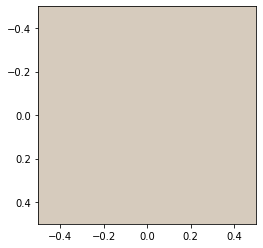

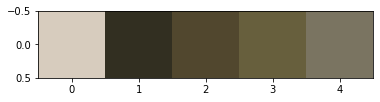

In [101]:
ct = ColorThief(output_paths[0])
print(output_paths[0])
dominant_color = ct.get_color(quality=1)
print(dominant_color)
plt.imshow([[dominant_color]])
plt.show()

palette = ct.get_palette(color_count = 5)
plt.imshow([[palette[i] for i in range(5)]])
plt.show()

In [11]:
dominant_color = []
palette_color = []

for i in range(len(df)):
    ct = ColorThief(output_paths[i])
    print(output_paths[i])
    dominant_color = ct.get_color(quality=1)
    print(dominant_color)
    

    palette = ct.get_palette(color_count = 5)
    palette_color.append([palette[j] for j in range(5)])

fashion_dataset_bgrem/americancasual/bgrem_americancasual_Men_082.png
(40, 33, 20)
fashion_dataset_bgrem/americancasual/bgrem_americancasual_Men_083.png
(202, 198, 198)
fashion_dataset_bgrem/americancasual/bgrem_americancasual_Men_084.png
(170, 159, 140)
fashion_dataset_bgrem/americancasual/bgrem_americancasual_Men_085.png
(60, 42, 19)
fashion_dataset_bgrem/americancasual/bgrem_americancasual_Men_086.png
(163, 137, 98)
fashion_dataset_bgrem/americancasual/bgrem_americancasual_Men_087.png
(24, 23, 21)
fashion_dataset_bgrem/americancasual/bgrem_americancasual_Men_088.png
(195, 164, 137)
fashion_dataset_bgrem/americancasual/bgrem_americancasual_Men_089.png
(110, 109, 95)
fashion_dataset_bgrem/americancasual/bgrem_americancasual_Men_090.png
(72, 67, 46)
fashion_dataset_bgrem/americancasual/bgrem_americancasual_Men_091.png
(198, 182, 150)
fashion_dataset_bgrem/americancasual/bgrem_americancasual_Men_092.png
(68, 62, 41)
fashion_dataset_bgrem/americancasual/bgrem_americancasual_Men_093.png
(

#### VGG16 기반 base Model 구축하기

In [12]:
class FeatureExtractor:
    def __init__(self):
        base_model = VGG16(weights='imagenet')
        print(base_model.summary())
        self.model = Model(inputs=base_model.input, outputs=base_model.get_layer('fc1').output)

    def extract(self, img):
        img = img.resize((224, 224))
        img = img.convert('RGB')
        x = image.img_to_array(img)
        x = np.expand_dims(x, axis=0)
        x = preprocess_input(x)
        
        feature = self.model.predict(x)[0]
        return feature / np.linalg.norm(feature)

In [13]:
features = []
img_paths = []
# categories = ['americancasual', 'casual', 'dandy', 'formal', 'sports', 'street']

fe = FeatureExtractor()


2023-02-22 09:04:38.347576: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

#### 이미지의 특징 추출 하기

In [ ]:
# for i in range(len(df)):
#     try:
#         image_path = df.iloc[i]['new_file_loc']
#         img_paths.append(image_path)
#         check = image_path.split('.')
        
#         feature = fe.extract(img=Image.open(image_path))
#         features.append(feature)
        
#         feature_path = 'features/' + check[0] + ".npy"
        
#         np.save(feature_path, feature)
#     except Exception as e:
#         print("예외가 발생했습니다.", e)

- 이미지 특징 추출은 최초 1번만 실행
- 추출된 특징은 features 폴더 내에 .npy로 저장되어 있음

In [38]:
df.iloc[0]['rem_img']

'fashion_dataset_bgrem/americancasual/bgrem_americancasual_Men_001.png'

In [14]:
features = []

for i in range(len(df)):
    png_path =df.iloc[0]['rem_img'].split('.') 
    path = 'features/'+ png_path[0] + '.npy'
    data = np.load(path)
    features.append(data)

1/1 [==============================] - 1s 658ms/step


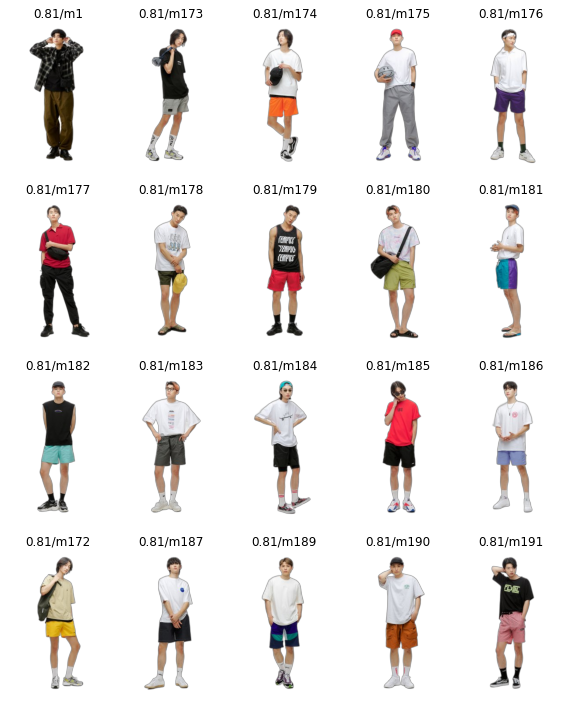

In [31]:
img = Image.open("query.png")
query = fe.extract(img)

dists = np.linalg.norm(features - query, axis=1)

# 오름차순 정렬의 인덱스 어레이를 반환
ids = np.argsort(dists)[:100]

scores = [(dists[id], df.iloc[id]['rem_img'], id) for id in ids]
tags = []

axes=[]
fig=plt.figure(figsize=(8,10))
for a in range(20):
    score = scores[a]
    axes.append(fig.add_subplot(4, 5, a+1))
    subplot_title=str(round(score[0],2)) + "/m" + str(score[2]+1)
    axes[-1].set_title(subplot_title)  
    plt.axis('off')
    plt.imshow(Image.open(score[1]))
    tags.append(df.iloc[score[2]]['NEW_TAG'])

fig.tight_layout()
plt.show()

In [116]:
scores

[(0.7651934,
  'fashion_dataset_bgrem/americancasual/bgrem_americancasual_Men_001.png',
  0),
 (0.7651934, 'fashion_dataset_bgrem/sports/bgrem_sports_Men_047.png', 1124),
 (0.7651934, 'fashion_dataset_bgrem/sports/bgrem_sports_Men_046.png', 1123),
 (0.7651934, 'fashion_dataset_bgrem/sports/bgrem_sports_Men_045.png', 1122),
 (0.7651934, 'fashion_dataset_bgrem/sports/bgrem_sports_Men_044.png', 1121),
 (0.7651934, 'fashion_dataset_bgrem/sports/bgrem_sports_Men_043.png', 1120),
 (0.7651934, 'fashion_dataset_bgrem/sports/bgrem_sports_Men_042.png', 1119),
 (0.7651934, 'fashion_dataset_bgrem/sports/bgrem_sports_Men_041.png', 1118),
 (0.7651934, 'fashion_dataset_bgrem/sports/bgrem_sports_Men_040.png', 1117),
 (0.7651934, 'fashion_dataset_bgrem/sports/bgrem_sports_Men_039.png', 1116),
 (0.7651934, 'fashion_dataset_bgrem/sports/bgrem_sports_Men_038.png', 1115),
 (0.7651934, 'fashion_dataset_bgrem/sports/bgrem_sports_Men_048.png', 1125),
 (0.7651934, 'fashion_dataset_bgrem/sports/bgrem_sports_Men

### 키워드 기반 검출

#### Tag에 나오는 term을 dictionary에 추가하기

In [16]:
dictionary = []
contents = []
new_tags = []

for i in range(len(df)):
    # print(len(df.iloc[i]['TAG']))
    tags = df.iloc[i]['NEW_TAG'][1:len(df.iloc[i]['NEW_TAG'])-1]
    # print(tags)
    # print()
    
    tags = re.split("[:/ ,']+", tags)
    tags.remove('')
    dictionary.extend(tags)
    contents.append((df.iloc[i]['PID'], tags))
    new_tags.append(tags)

dictionary = list(set(dictionary))
print('len of dictionary : ', len(dictionary))
dictionary.sort()

dictionary.remove('')
dictionary = dictionary[1:]
print('len of dictionary : ', len(dictionary))


len of dictionary :  782
len of dictionary :  780


#### Inverted Index - posting

In [17]:
dict_post = {}
for term in dictionary:
    
    posting = {}
    
    for id , t1 in contents:
        # print(idx, tags)    
        freq = 0
        for t2 in t1:
            if (term == t2):
                print("ID : ", id, "Term : ", term, " Word : ", t2) 
                freq += 1
        if (freq != 0):
            posting[id] = freq
    
    dict_post[term] = posting
    print(term)    

ID :  Men-for188 Term :  210에디트  Word :  210에디트
210에디트
ID :  Men-str291 Term :  2113  Word :  2113
2113
ID :  Men-for150 Term :  235연구소  Word :  235연구소
235연구소
ID :  Men-str239 Term :  Y2K  Word :  Y2K
Y2K
ID :  Men-spo294 Term :  가치  Word :  가치
가치
ID :  Men-str236 Term :  감마갤러리  Word :  감마갤러리
ID :  Men-str238 Term :  감마갤러리  Word :  감마갤러리
ID :  Men-str246 Term :  감마갤러리  Word :  감마갤러리
ID :  Men-str247 Term :  감마갤러리  Word :  감마갤러리
ID :  Men-str249 Term :  감마갤러리  Word :  감마갤러리
ID :  Men-str261 Term :  감마갤러리  Word :  감마갤러리
ID :  Men-str270 Term :  감마갤러리  Word :  감마갤러리
감마갤러리
ID :  Men-ame098 Term :  거트  Word :  거트
ID :  Men-ame103 Term :  거트  Word :  거트
ID :  Men-spo078 Term :  거트  Word :  거트
ID :  Men-spo094 Term :  거트  Word :  거트
ID :  Men-spo284 Term :  거트  Word :  거트
ID :  Men-spo300 Term :  거트  Word :  거트
ID :  Men-str278 Term :  거트  Word :  거트
ID :  Men-str288 Term :  거트  Word :  거트
거트
ID :  Men-for184 Term :  겐지  Word :  겐지
겐지
ID :  Men-for162 Term :  격식  Word :  격식
ID :  Men-for193 T

#### tf-idf 적용하기

In [18]:
from math import log10
N = len(df)

def tf(t, d):
    if d in dict_post[t]:
        return 1+log10(dict_post[t][d])
    else:
        return 0

def idf(t):
    df = len(dict_post[t])
    return log10(N/(df))

def tfidf(t, d):
    return tf(t,d)* idf(t)

In [19]:
['파스텔', '컬러포인트', '스티치', '스트라이프', '화사한', '환절기', '꾸안꾸', '여름', '캐주얼', '캐터필라와치', '무신사', '스탠다드', '언다이드룸', '런디에스', '쿼츠', '아날라고ㅡ', '메신저', '크로스', '셔츠', '블라우스', '반소매', '티셔츠', '캔버스', '단화', '캡', '야구', '모자', '슈트', '팬츠', '슬랙스']

['파스텔',
 '컬러포인트',
 '스티치',
 '스트라이프',
 '화사한',
 '환절기',
 '꾸안꾸',
 '여름',
 '캐주얼',
 '캐터필라와치',
 '무신사',
 '스탠다드',
 '언다이드룸',
 '런디에스',
 '쿼츠',
 '아날라고ㅡ',
 '메신저',
 '크로스',
 '셔츠',
 '블라우스',
 '반소매',
 '티셔츠',
 '캔버스',
 '단화',
 '캡',
 '야구',
 '모자',
 '슈트',
 '팬츠',
 '슬랙스']

In [20]:
query = input("Query : ")
tr_query = query.split(" ")
print(tr_query)

['파스텔', '컬러포인트', '스티치', '스트라이프', '화사한', '환절기', '꾸안꾸', '여름', '캐주얼', '캐터필라아치', '무신사', '스탠다드', '언다이드룸', '런디에스', '쿼츠', '아날로그', '메신저', '크로스', '셔츠', '블라우스', '반소매', '티셔츠', '캔버스', '단화', '캡', '야구', '모자', '슈트', '팬츠', '슬랙스']


In [22]:
feature_extra_scores = scores
keyword_result = []
keyword_scores = []
keyword_max_score = 0

for id in range(len(feature_extra_scores)):
    score = 0
    for term in tr_query:
        if term in dictionary:
            # print(df.iloc[product]['PID'], ' : ', term)
            score += tfidf(term, df.iloc[id]['PID'])
            # print(score)
        else:
            pass
    keyword_scores.append((score, df.iloc[id]['PID']))
    
    if (score > 0):
        keyword_result.append((score, df.iloc[id]['PID']))

    if score > keyword_max_score:
        keyword_max_score = score
        
keyword_result.sort(reverse=True)

In [32]:
n_count = 0
show_result = []

for r in keyword_result:
    if r[0] == keyword_max_score:
        show_result.append(r)
        n_count += 1
    elif n_count < 20:
        show_result.append(r)
        n_count += 1
    else:
        break

In [33]:
result_img = []
for r in show_result:
    score, id = r[0], r[1]
    for i in range(len(df)):
        if df.iloc[i]['PID'] == id:
            result_img.append((df.iloc[i]['file_loc'], df.iloc[i]['NEW_TAG']))

# result_img

Search Keywords :  ['파스텔', '컬러포인트', '스티치', '스트라이프', '화사한', '환절기', '꾸안꾸', '여름', '캐주얼', '캐터필라아치', '무신사', '스탠다드', '언다이드룸', '런디에스', '쿼츠', '아날로그', '메신저', '크로스', '셔츠', '블라우스', '반소매', '티셔츠', '캔버스', '단화', '캡', '야구', '모자', '슈트', '팬츠', '슬랙스']  에 대한 키워드 매칭 검색 결과 입니다.


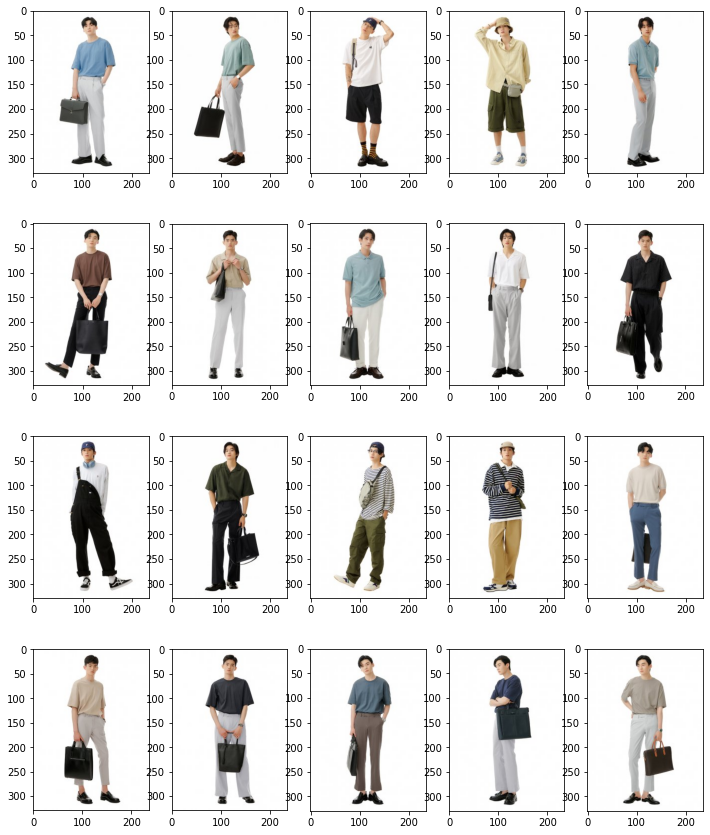

In [39]:
print("Search Keywords : " , tr_query , " 에 대한 키워드 매칭 검색 결과 입니다.")
fig = plt.figure(figsize=(12,15))

for n in range(len(result_img)):
    fig.add_subplot(4,5, n+1)
    orig_img = Image.open(result_img[n][0])
    plt.imshow(orig_img)
    # print(result_img[n][1])